# pyfixp: Implementing fixpoint filters #
This notebook shows how to use fixpoint filters from the ``pyfixp.filters`` submodule.


In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

import pyfixp.pyfixp as fx
print("pyfixp version = ", fx.__version__)
%matplotlib inline    

import matplotlib.pyplot as plt

plt.style.use('script.mplstyle')
import numpy as np
import scipy.signal as sig

figsize = {"figsize":(13,7)}

pyfixp version =  0.9.0


## FIR Filters

The following cell designs an equiripple FIR low pass filter and plots its impulse response (same as the coefficients) $h[n]$ and its ideal magnitude frequency response $|H_{id}(F)|$.

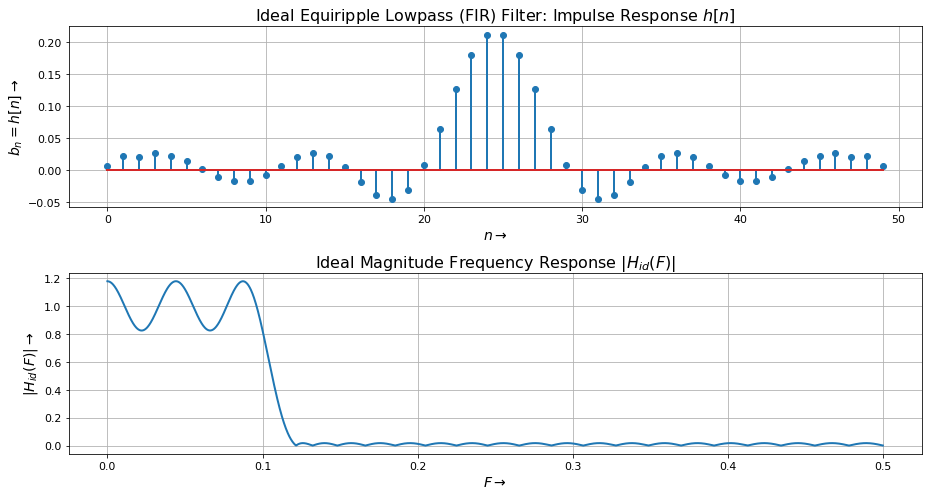

In [2]:
numtaps = 50 # filter order
N_FFT = 2000 # number of frequency bins per half plane
b_FIR = sig.remez(numtaps,[0,0.1,0.12, 0.5], [1,0], [1,10]) # [frequency bands], [target frequency response], [weights]
w, H = sig.freqz(b_FIR, [1], worN=N_FFT)
f = w / (2*np.pi)
fig, (ax1, ax2) = plt.subplots(2, **figsize); ax1.grid(True); ax2.grid(True)
ax1.set_title('Ideal Equiripple Lowpass (FIR) Filter: Impulse Response $h[n]$')
ax1.stem(np.arange(numtaps), b_FIR, use_line_collection=True)
ax1.set_xlabel(r'$n \rightarrow$'); ax1.set_ylabel(r'$b_n = h[n] \rightarrow$')
ax2.set_title('Ideal Magnitude Frequency Response $|H_{id}(F)|$')
ax2.plot(f,np.abs(H))
ax2.set_xlabel(r'$F \rightarrow$'); ax2.set_ylabel(r'$|H_{id}(F)| \rightarrow$')
fig.set_tight_layout(True)

If you want to obtain the transient response to an arbitrary stimulus $x[n]$, you need to convolve the stimulus with the input response, $y[n] = x[n] \ast h[n]$. The result of the convolution has the length `len(y) = len(x) + len(h) -1` so it needs to be truncated for plotting against the time vector `n`. Scipy's `lfilter(b,a,x)` function yields the same result but is more comfortable to use. The filter needs `numtaps` input pulses to be fully settled, that's why the first `numtaps` pulses of the response are discarded for calculating the spectrum response.

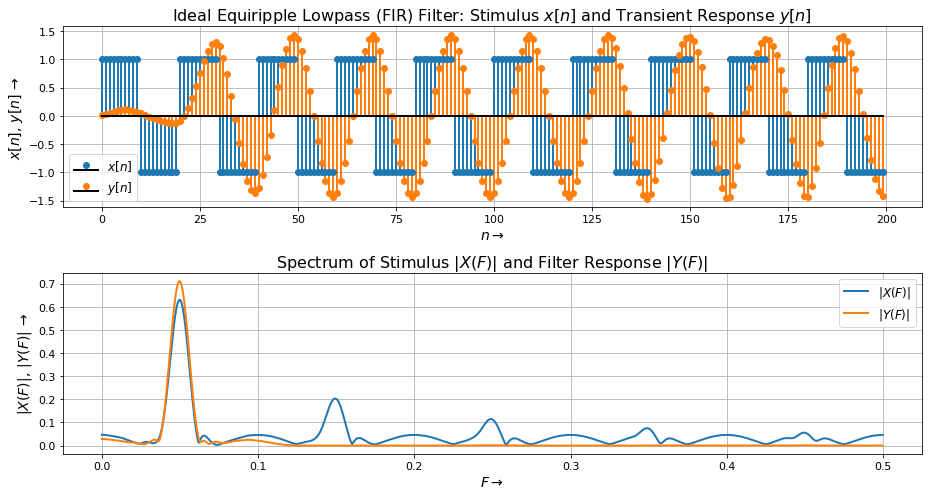

In [19]:
N = 200; n = np.arange(N) # length of time vector and time vector
N_FFT = 2000 # number of frequency bins per half plane
x = np.sin(2 * np.pi * n / 20)
x = sig.square(2 * np.pi * n / 20)
# y = np.convolve(x, b_FIR)[:N]
y = sig.lfilter(b_FIR, [1], x)
sig_len = len(x[numtaps:])
X = np.abs(np.fft.rfft(x[numtaps:]*2*sig.windows.hann(sig_len), 2*N_FFT)[:-1])/sig_len
Y = np.abs(np.fft.rfft(y[numtaps:]*2*sig.windows.hann(sig_len), 2*N_FFT)[:-1])/sig_len

fig, (ax1, ax2) = plt.subplots(2, **figsize); ax1.grid(True); ax2.grid(True)
ax1.set_title('Ideal Equiripple Lowpass (FIR) Filter: Stimulus $x[n]$ and Transient Response $y[n]$')
ax1.stem(n, x, basefmt = 'k', use_line_collection=True, label="$x[n]$")
ax1.stem(n, y, 'C1', markerfmt = 'C1o', basefmt = 'k', use_line_collection=True, label="$y[n]$")
ax1.set_xlabel(r'$n \rightarrow$'); ax1.set_ylabel(r'$x[n], \, y[n]\, \rightarrow$')
ax1.legend()
ax2.set_title('Spectrum of Stimulus $|X(F)|$ and Filter Response $|Y(F)|$')
ax2.plot(f,X,label="$|X(F)|$"); ax2.plot(f,Y, label="$|Y(F)|$")
ax2.set_xlabel(r'$F \rightarrow$'); ax2.set_ylabel(r'$|X(F)|, \, |Y(F)|\, \rightarrow$')
ax2.legend()
fig.set_tight_layout(True)

Fixpoint filters process quantized input data (quantizer $Q_X$ in the image and code below), with quantized coeffients ($Q_b$ in the code) and have a quantized accumulator $Q_A$ and a quantized output ($Q_Y$). All these quantizers are characterized by their word length, rounding and overflow behaviour. The following Fig. 1 shows the topology of a direct form FIR fixpoint filter.
<figure>
   <center>
    <img src='img/fir_df.png' alt='Direct Form FIR Filter' width='30%'/>
    <figcaption><b>Fig. 1:</b> Direct Form FIR Fixpoint Filter</figcaption>
   </center>
</figure>
Due to the non-linear effects of quantization, fixpoint filters can only be simulated in the time domain. In contrast to an ideal linear filter, the topology can have a large impact on the performance (SQNR, overflow behaviour, ...) of fixpoint filters. An approximated (linearized) frequency response can be obtained from the Fourier transform of the impulse response (see next code cell).

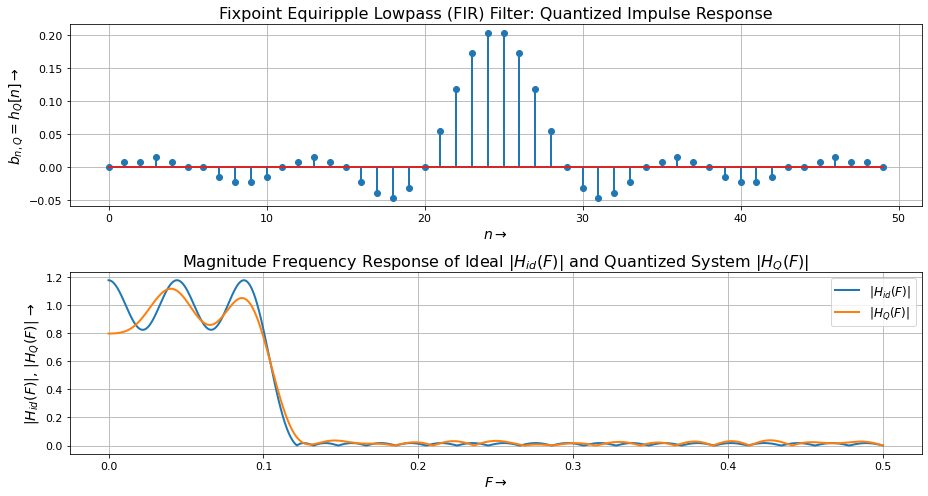

In [14]:
from pyfixp.filters.fir_df import FIR_DF
N = 200
# Define and instantiate quantizers
q_bxy = {'WI':0, 'WF': 7, 'quant':'floor', 'ovfl': 'sat'} # quantization dict for x, q and coefficients
q_mul = q_accu = {'WI':0, 'WF': 15, 'quant':'floor', 'ovfl': 'wrap'} # ... for accumulator
Q_X = fx.Fixed(q_bxy); Q_Y = fx.Fixed(q_bxy)
Q_b = fx.Fixed(q_bxy); Q_accu = fx.Fixed(q_accu)
b_FIRq = Q_b.fixp(b_FIR) # quantized coefficients
# Instantiate FIR filter with quantized coefficients and quantizer settings for the accumulator
fil_q = FIR_DF(b_FIRq, q_accu) 
#fil_q = FIR_DF(bq, q_accu, q_mul) # optional: requantization after each multiplier
x = np.zeros(N); x[0] = 1 # define unit impulse
# x = np.sin(np.arange(N)*np.pi*2 / 20) # alternative stimulus, will create overflows
xq = Q_X.fixp(x)                 # quantize input signal
y_fil = fil_q.fxfilter(None,xq)  # filter input signal, result is quantized to accumulator settings
yq = Q_Y.fixp(y_fil)             # quantize with QY quantizer. Setting q_accu = q_bxy would achieve the same
# Plot results
fig, (ax1, ax2) = plt.subplots(2, **figsize); ax1.grid(True); ax2.grid(True)
ax1.set_title('Fixpoint Equiripple Lowpass (FIR) Filter: Quantized Impulse Response')
ax1.stem(np.arange(min(numtaps, len(x))), yq[:(min(numtaps, len(x)))], use_line_collection=True)
ax1.set_xlabel(r'$n \rightarrow$'); ax1.set_ylabel(r'$b_{n,Q} = h_Q[n] \rightarrow$')
ax2.set_title('Magnitude Frequency Response of Ideal $|H_{id}(F)|$ and Quantized System $|H_{Q}(F)|$')
ax2.plot(f,np.abs(H), label="$|H_{id}(F)|$")
ax2.plot(f, np.abs(np.fft.rfft(yq, 2*N_FFT)[:-1]), label = "$|H_{Q}(F)|$")
ax2.set_xlabel(r'$F \rightarrow$'); ax2.set_ylabel(r'$|H_{id}(F)|, \,|H_Q(F)|\, \rightarrow$')
ax2.legend()
fig.set_tight_layout(True)

## IIR Filters
Unlike FIR filters, IIR filters cannot be implemented with the same elegance and efficiency of array mathematics as each sample depends on the output sample as well. The following code cell designs an elliptic low pass filter and plots its magnitude frequency response.

The topology of fixpoint IIR filters is much more important for its performance than for FIR filters. It can make a large difference for IIR filters in which order recursive and transversal part of the filter are calculated (direct form 1 vs. direct form 2) which is not the case for ideal systems.

b= [ 0.01967691 -0.01714282  0.03329653 -0.01714282  0.01967691]
a= [ 1.         -3.03302405  3.81183153 -2.29112937  0.5553678 ]


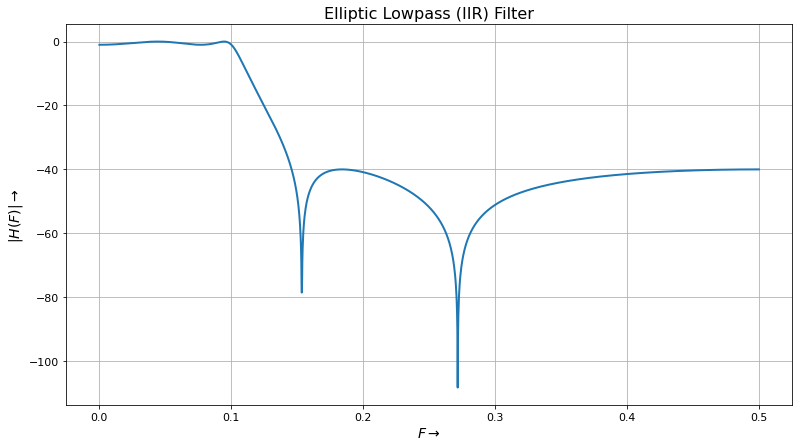

In [5]:
b_IIR,a_IIR = sig.ellip(4,1,40, 2*0.1) # order, pass band ripple, stop band ripple, corner frequency w.r.t. f_S/2
w, h = sig.freqz(b_IIR,a_IIR, worN=2000)
fig, ax = plt.subplots(1, **figsize); ax.grid(True)
ax.set_title('Elliptic Lowpass (IIR) Filter')
ax.plot(w / (2*np.pi),20*np.log10(np.abs(h)))
ax.set_xlabel(r'$F \rightarrow$'); ax.set_ylabel(r'$|H(F)| \rightarrow$')
print("b=", b_IIR)
print("a=", a_IIR)

<figure>
     <center>
    <img src='img/iir_df1_df2.png' alt='Direct Form IIR Filter' width='60%'/>
    <figcaption><b>Fig. 2:</b> Direct Form IIR Filter Type 1 and 2</figcaption>
 </center>
</figure>

The following two examples show how to implement the most simple recursive filters (no transversal path, i.e. "all-pole filters") and test them.

In [6]:
def IIR1(Q_ACCU, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-1] + a y[i-1] >
    """
    y = np.zeros(len(x))
    for i in range(0,len(x)-1):
        y[i+1] = Q_ACCU.fixp(x[i] + a * y[i])
    return y
    
def IIR2(Q_ACCU, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-2] + y[i-1] - a y[i-2] >
    """
    y = np.zeros(len(x))
    for i in range(len(x)-2):
        y[i+2] = Q_ACCU.fixp(x[i] + y[i+1] - y[i]*a)
    return y

Quantization and overflows in IIR-filters can create so called "zero-input limit cycles", i.e. there is a constant or periodic signal at the filter output although the input signal has been turned off.

- **Small scale limit cycles** can result when the absolute signal value grows during requantization (energy is added). This can happen (depending on the sign) with `'round'` und `'floor'` auftreten. With the `'fix'` setting, the magnitude never grows, avoiding limit cycles. To see some small scale limit cycles, try the IIR1 filter with the settings
`alpha = +/-0.9` and `q_accu = {'Q':(0,4),'quant':'round','ovfl':'sat'}`

- **Large scale limit cycles** can be triggered by overflows. Saturation logic prevents this kind of overflow. To see some large scale limit cycles, try the IIR2 filter with the following settings
`alpha = +0.9`, `x[0] = 1` and `q_accu = {'Q':(0,4),'quant':'round','ovfl':'wrap'}`

Try out the settings `'floor'` and `'sat'` as well to test their impact on limit cycle creation.

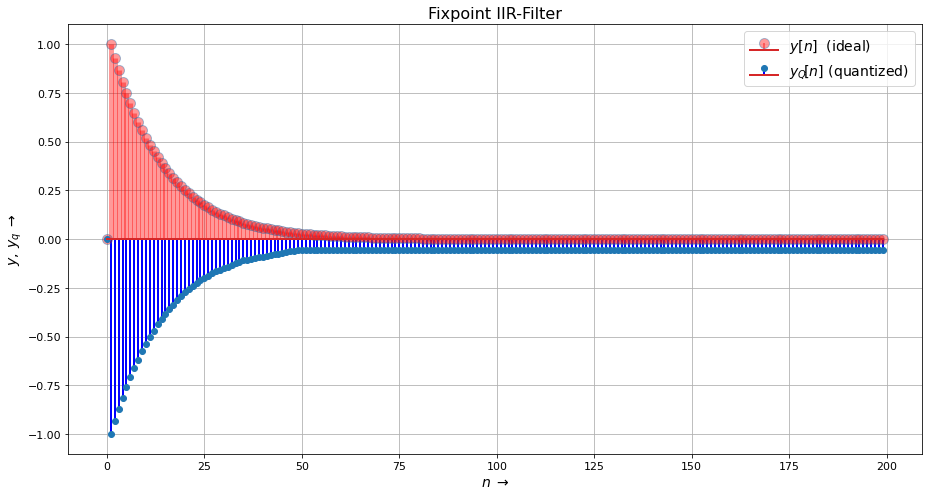

In [7]:
alpha = 0.93 # coefficient
N_sim = 200 # number of simulation steps
x = np.zeros(N_sim); x[0] = 1.0 # x is dirac pulse with weight 1
 
q_x = {'WI':0,'WF':3,'quant':'round','ovfl':'sat'} # fixpoint quantization for stimulus
q_coeff = {'WI':0,'WF':3,'quant':'round','ovfl':'wrap'} # coefficient quantization dict
# quantizer settings for accumulator
#q_accu = {'WI':0,'WF':4,'quant':'fix','ovfl':'sat'} # saturation and round towards zero -> no limit cycles
q_accu = {'Q':0.8,'quant':'floor','ovfl':'wrap'}  # 'floor' and 'wrap': large scale limit cy^cles for  QI = 0
# kleine Grenzzyklen mit round / floor, abhängig von alpha:
# q_accu = {'WI':0,'WF':4,'quant':'floor','ovfl':'wrap'} 

# Keine Quantisierung ->  Werte für I, F beliebig
q_ideal = {'WI':0,'WF':0,'quant':'none','ovfl':'none'}

Q_coeff = fx.Fixed(q_coeff) # Fixpoint Object with parameters "q_coeff"

Q_ideal = fx.Fixed(q_ideal) # Fixpoint object without quantisation and overflow 
Q_accu = fx.Fixed(q_accu) # Fixpoint object defined by dictionary "q_accu"

n = np.arange(N_sim)
t1 = time.perf_counter()
alpha_q = Q_ideal.fixp(alpha)

y = IIR1(Q_ideal, x, alpha_q) # no quantization
yq = IIR1(Q_accu, x, alpha_q)
#yq = IIR2(Q_accu, x, alpha_q)


fig1, ax1 = plt.subplots(**figsize); ax1.grid(True)
ax1.set_title('Fixpoint IIR-Filter')

mly, sly, bly = ax1.stem(n,y, label = r'$y[n]\;$ (ideal)', use_line_collection=True)
plt.setp(mly, 'markerfacecolor', 'r', 'markersize', 10 ,'alpha', 0.4) # markerline
plt.setp(sly, 'color','r', 'linewidth', 5, 'alpha', 0.4) # stemline
ax1.stem(n, yq, 'b', label = r'$y_Q\![n]$ (quantized)', use_line_collection=True)
ax1.legend(fontsize = 14); 
ax1.set_xlabel(r'$n \; \rightarrow$')
ax1.set_ylabel(r'$y,\, y_q \; \rightarrow$')
#
fig1.set_tight_layout(True)

***
### Copyright

(c) 2016 - 2020 Christian Münker 

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources) , feel free to use it for your own purposes. Please attribute the work as follows: *Christian Münker, pyfixp documentation*.